In [ ]:
#Isolation forest

In [16]:
# Using h2o's Isolation forest function
import h2o
from h2o.estimators import H2OIsolationForestEstimator
h2o.init()

h2o_df = h2o.import_file("apple.csv")
h2o_df = h2o_df[:,0:6]
train=h2o_df[1:]
# Build an Isolation forest model
model = H2OIsolationForestEstimator(sample_rate = 0.1,
                                    max_depth = 20,
                                    ntrees = 50)
model.train(training_frame=h2o_df)

# Calculate score
predictions = model.predict(h2o_df)
result_pred = predictions["predict"]

# Predict the leaf node assignment
ln_pred = model.predict_leaf_node_assignment(h2o_df, "Path")

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O cluster uptime:,15 mins 35 secs
H2O cluster timezone:,Asia/Kolkata
H2O data parsing timezone:,UTC
H2O cluster version:,3.24.0.3
H2O cluster version age:,10 days
H2O cluster name:,H2O_from_python_root_uhna22
H2O cluster total nodes:,1
H2O cluster free memory:,1.575 Gb
H2O cluster total cores:,4
H2O cluster allowed cores:,4
H2O cluster status:,"locked, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
isolationforest Model Build progress: |███████████████████████████████████| 100%
isolationforest prediction progress: |████████████████████████████████████| 100%


In [39]:
predictions.head()
#the column'predict' here is the anomaly score calculated by the algorithm

,predict,mean_length
0,0.564384,7.24
1,0.397260,8.46
2,0.542466,7.40
3,0.512329,7.62
4,0.400000,8.44


In [17]:
#finding the top 5% points with highest anomaly score
predictions = predictions.as_data_frame()
quantile = 0.95
quantile_frame = predictions.quantile([quantile])
print(quantile_frame)
threshold = quantile_frame.iloc[0,0]
predictions1 = predictions["predict"] > threshold

       predict  mean_length
0.95  0.506849         10.8


In [19]:
import matplotlib.pyplot as plt   # Import matplotlib
# This line is necessary for the plot to appear in a Jupyter notebook
%matplotlib inline
# Control the default size of figures in this Jupyter notebook
%pylab inline
pylab.rcParams['figure.figsize'] = (15, 9)

Populating the interactive namespace from numpy and matplotlib


In [20]:
data=h2o_df.as_data_frame()
data['predict']=predictions['predict']
data['mean_length']=predictions['mean_length']
data['95QT']=predictions1

In [ ]:
for index,row in data.iterrows():
    if row['95QT']==True:
        plt.scatter(row['Date'],row['Close'],color='red')
# plt.hlines(y=threshold,xmin=0,xmax=len(predictions))

data['Close'].plot()
plt.show()

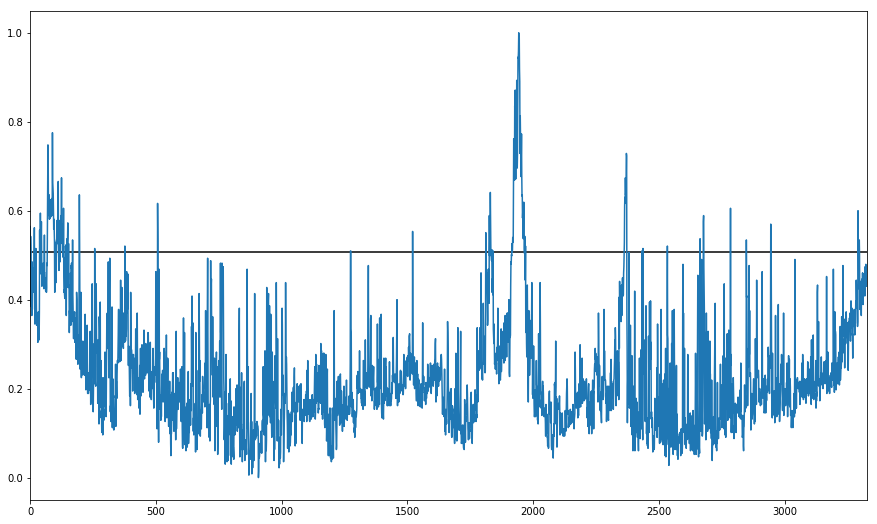

In [22]:
data['predict'].plot()
plt.hlines(y=threshold,xmin=0,xmax=len(predictions))
#plot for anomaly score, The horizontal line represents 95 percentile

In [29]:
#smoothening the anomaly score curve by taking average over a range
data['smoothansc']=0
for index,row in data.iterrows():
    rangevar1=10
    if(index<rangevar1):
        rangevar1=index+1
#     for i in range(rangevar1):
#         sum =sum+data['predict'].iloc[index-i]
    sum = data['predict'].iloc[index-rangevar1:index+rangevar1].sum()
    data['smoothansc'].iloc[index]=sum/(2*rangevar1)
    update_progress(index /len(data))
update_progress(1)

Progress: [####################] 100.0%


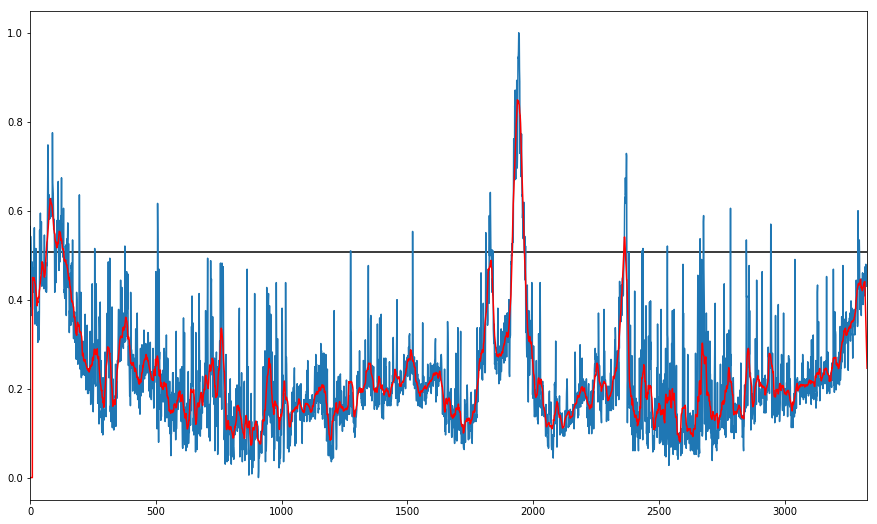

In [30]:
data['predict'].plot()
data['smoothansc'].plot(color='red')
plt.hlines(y=threshold,xmin=0,xmax=len(predictions))

In [35]:
#instead of taking global top anomalies, we take into consideration only the past n data points to find local anomalies
quantile=0.96
data['quantile']=0
rangevar=20
for index,row in data.iterrows():
    if(index>rangevar):
        predictions1 = data['predict'][index-rangevar:index]
    else:
        predictions1 = data['predict'][0:index]
    quantile_frame = predictions1.quantile([quantile])
    data['quantile'][index]=quantile_frame.iloc[0]
    update_progress(index /len(data))

Progress: [####################] 100.0%


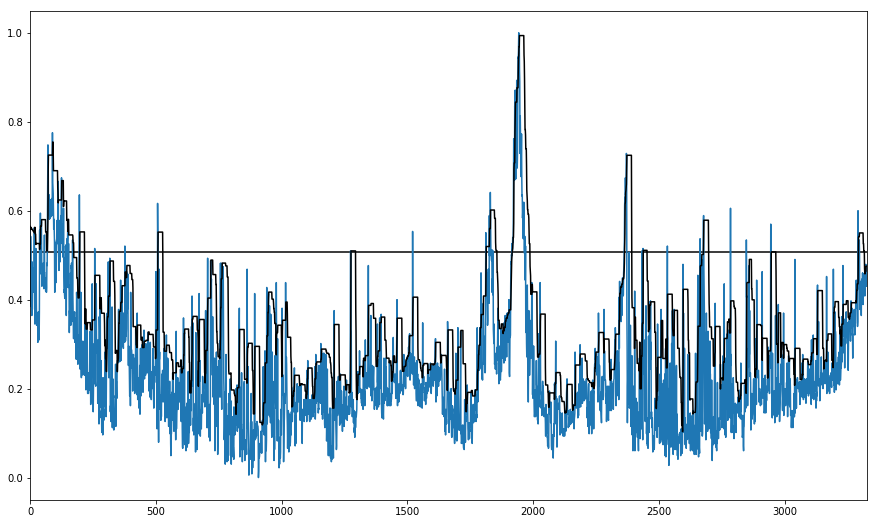

In [36]:
#plotting the local percentile lines
data['predict'].plot()
data['quantile'].plot(color='black')
plt.hlines(y=threshold,xmin=0,xmax=len(predictions))

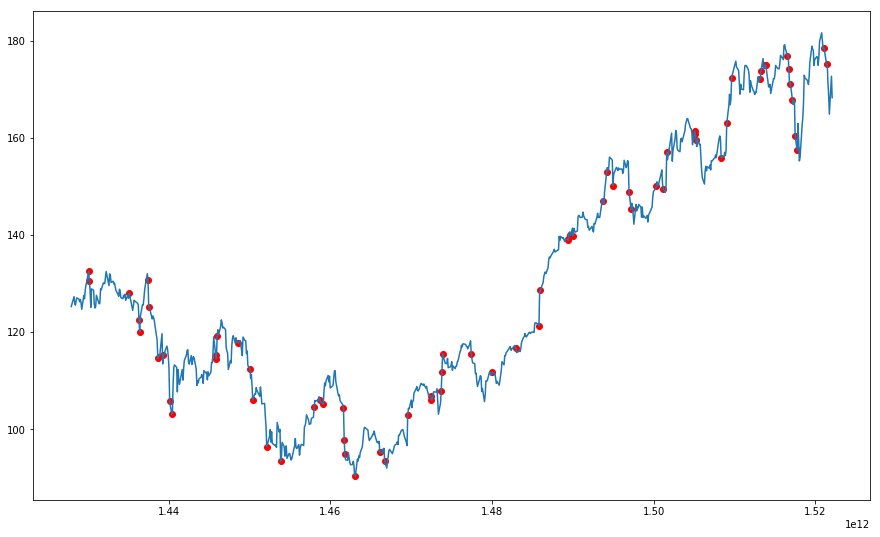

In [37]:
#plotting local anomalies on time series graph
data['is_anomaly']=data['quantile'] < data['predict']
for index,row in data.iterrows():
    if row['is_anomaly']==True and index>len(data)-750:
        plt.scatter(row['Date'],row['Close'],color='red')
# plt.hlines(y=threshold,xmin=0,xmax=len(predictions))

plt.plot(data['Date'].iloc[-750:],data['Close'].iloc[-750:])
plt.show()

In [27]:
#code for progress bar used in above code
import time, sys
from IPython.display import clear_output

def update_progress(progress):
    bar_length = 20
    if isinstance(progress, int):
        progress = float(progress)
    if not isinstance(progress, float):
        progress = 0
    if progress < 0:
        progress = 0
    if progress >= 1:
        progress = 1

    block = int(round(bar_length * progress))

    clear_output(wait = True)
    text = "Progress: [{0}] {1:.1f}%".format( "#" * block + "-" * (bar_length - block), progress * 100)
    print(text)